# Dog Breed Classification with Deep Learning 🐕‍🦺
Autor: Miguel Vásquez  
Date: September 2025  

---

## 1. Introduction

In this project we tackle the task of **dog breed classification (120 classes)** using the **Stanford Dogs dataset**.  
Our main goal is to **compare two preprocessing strategies**:
- Using full images
- Using cropped images based on bounding boxes from annotations  

We leverage **Convolutional Neural Networks (CNNs)** and **transfer learning** with pre-trained architectures (e.g., ResNet, EfficientNet) to extract rich visual features and achieve high classification accuracy.  

To improve performance, we apply techniques such as **data augmentation, fine-tuning of upper layers, and class imbalance handling.** Beyond model performance, we emphasize interpretability and visualizations (e.g., **Grad-CAM heatmaps**) to understand how the model makes its predictions.  

This project demonstrates a complete end-to-end workflow in deep learning for image classification — from dataset exploration and preprocessing to training, evaluation, and interpretability.

---

## 2. Dataset & Setup  
### 2.1 Data import

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

import warnings
from IPython.display import display, Markdown

warnings.filterwarnings("ignore")

import kagglehub
# Download dataset
DATASET_PATH = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
display(Markdown(f"**Dataset Path:** {DATASET_PATH}"))

**Dataset Path:** C:\Users\Miguel\.cache\kagglehub\datasets\jessicali9530\stanford-dogs-dataset\versions\2

### 2.2 Dataset structure

images/ → breed-specific folders containing dog photos

annotations/ → XML files with bounding boxes and metadata

We will visualize a few random examples of images and their annotations.

---

### 2.3 Train/Validation/Test split

To ensure that our model can generalize, we split the dataset into **train**, **validation**, and **test** subsets.  
- **Train set (70%)** → used to fit the model’s parameters.  
- **Validation set (15%)** → used to tune hyperparameters and prevent overfitting.  
- **Test set (15%)** → used for final unbiased evaluation.  

We apply a **stratified split** by breed, so each subset maintains the same class distribution.

In [9]:
# Images path
IMAGES_PATH = os.path.join(DATASET_PATH, "images", "Images")
OUTPUT_PATH = "dogs_split"

# Clean up any existing folders
for folder in [OUTPUT_PATH, "train", "test", "valid"]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Create output directories
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(OUTPUT_PATH, split), exist_ok=True)

# Parameters
TEST_SIZE = 0.15   # 15% test
VALID_SIZE = 0.15

def split_data(images_path, output_path, test_size=TEST_SIZE, valid_size=VALID_SIZE):
    # Get all breed directories
    breeds = [d for d in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, d))]
    
    for breed in breeds:
        breed_path = os.path.join(images_path, breed)
        images = [f for f in os.listdir(breed_path) if os.path.isfile(os.path.join(breed_path, f))]
        
        # Split into train+valid and test
        train_valid_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        # Further split train+valid into train and valid
        train_imgs, valid_imgs = train_test_split(train_valid_imgs, test_size=valid_size/(1-test_size), random_state=42)
        
        # Create breed directories in output folders
        for split, img_list in zip(['train', 'valid', 'test'], [train_imgs, valid_imgs, test_imgs]):
            split_breed_path = os.path.join(output_path, split, breed)
            os.makedirs(split_breed_path, exist_ok=True)
            for img in img_list:
                shutil.copy(os.path.join(breed_path, img), os.path.join(split_breed_path, img))
    display(Markdown(f"✅ Dataset split into train/valid/test in the folder: {output_path}"))

split_data(IMAGES_PATH, OUTPUT_PATH)

✅ Dataset split into train/valid/test in the folder: dogs_split

## 3. Methodology  
### 3.1 Model architecture  
We leverage **ResNet50**, a deep convolutional neural network architecture pretrained on the **ImageNet** dataset. ResNet introduced the concept of residual connections, which allow gradients to flow more easily during backpropagation, mitigating the vanishing gradient problem in very deep networks.

By using a pretrained model, we benefit from **transfer learning**: the early layers capture generic visual features (edges, textures, shapes), while only the final layers are adapted to our specific task. We replace the last fully connected layer with a new one of size **120**, corresponding to the number of dog breeds in the Stanford Dogs dataset.

This approach significantly reduces training time and improves accuracy compared to training a CNN from scratch.

In [10]:
# Base model
model = models.resnet50(weights="IMAGENET1K_V1")

# Final layer 120 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 120)

### 3.2 Global hyperparameters
We define the global hyperparameters that control our training process. These values affect optimization, regularization, and runtime efficiency:

- **Batch size (64):** number of samples processed at once by the GPU.  
- **Image size (224):** input resolution for ResNet50 (standard for ImageNet pretrained models).  
- **Epochs (10):** total passes over the training dataset.  
- **Learning rate (1e-3):** controls the step size during optimization.  
- **Weight decay (1e-4):** L2 regularization to reduce overfitting.  
- **Early stopping patience (3):** stop training if validation accuracy does not improve.  
- **Learning rate scheduler:** reduces learning rate by a factor of 0.1 after 2 stagnant epochs.  
- **Automatic Mixed Precision (AMP):** improves training speed and reduces memory usage by using float16 where safe.  

In [11]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Global hyperparameters
BATCH_SIZE = 64
IMG_SIZE = 224
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 3
LR_SCHEDULER_FACTOR = 0.1
LR_SCHEDULER_PATIENCE = 2 

# AMP (Automatic Mixed Precision)
USE_AMP = True

display(Markdown(f"✅ Using device: {device}"))


✅ Using device: cuda

### 3.3 Data preprocessing
To efficiently train our model, we preprocess the dataset as follows:

- **Image Transforms**:  
  - *Training*: random resized crops, horizontal flips, and normalization (data augmentation).  
  - *Validation/Test*: center crop and normalization only.  

- **Imbalance Handling**:  
  We compute class weights and use a `WeightedRandomSampler` to ensure that under-represented breeds  
  are sampled more frequently during training.  

- **DataLoader Integration**:  
  We encapsulate everything into a function that prepares `DataLoader`s for train, validation, and test sets.

In [12]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

def get_dataloaders(data_dir, batch_size=BATCH_SIZE, img_size=IMG_SIZE):

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    eval_transforms = transforms.Compose([
        transforms.Resize(int(img_size*1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    # Load datasets
    image_datasets = {
        "train": datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms),
        "valid": datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=eval_transforms),
        "test": datasets.ImageFolder(os.path.join(data_dir, "test"), transform=eval_transforms),
    }
    
    # Compute class weights for imbalance handling
    targets = [label for _, label in image_datasets["train"].samples]
    class_counts = Counter(targets)
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in targets]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create DataLoaders
    dataloaders = {
        "train": DataLoader(image_datasets["train"], batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True),
        "valid": DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
        "test": DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
    }
    
    display(Markdown("✅ DataLoaders ready: with augmentation, normalization, and imbalance handling."))
    return dataloaders, image_datasets

dataloaders, image_datasets = get_dataloaders(OUTPUT_PATH)


✅ DataLoaders ready: with augmentation, normalization, and imbalance handling.

## 4. Training & Evaluation  
### 4.1 Define loss function and optimizer  
We'll use CrossEntropyLoss because it's a multiclass classification problem.  
As the optimizer, we start with Adam.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Number of classes
num_classes = len(image_datasets["train"].classes)
class_names = image_datasets["train"].classes

### 4.2 Training loop & Validation  

The training loop in deep learning typically follows these key steps:  

- **Forward pass** → The model processes the input data and outputs predictions.  
- **Loss computation** → The difference between predictions and true labels is quantified using a loss function.  
- **Backward pass** → Gradients of the loss with respect to model parameters are computed via backpropagation.  
- **Optimizer step** → The optimizer updates the weights based on gradients.  
- **Logging** → Track metrics like training/validation loss and accuracy across epochs.  
- **Validation** → After each epoch, evaluate on the validation set to monitor generalization.  
- **Checkpointing** → Save the best-performing model (based on validation accuracy).  


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS, device=device, save_path="best_model.pth"):
    scaler = torch.cuda.amp.GradScaler()
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

    for epoch in range(num_epochs):
        display(Markdown(f" Epoch {epoch+1}/{num_epochs}  \n"
                         f"{'-' * 20}"))
                         
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double().item() / total_samples

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            display(Markdown(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}"))

            # Save best model
            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), save_path)

    display(Markdown(f"\n✅ Best Validation Accuracy: {best_acc:.4f}"))
    return model, history
trained_model, history = train_model(model.to(device), dataloaders, criterion, optimizer, num_epochs=EPOCHS, device=device)

 Epoch 1/10  
--------------------

train Loss: 4.6214 Acc: 0.0264

valid Loss: 4.7671 Acc: 0.0434

 Epoch 2/10  
--------------------

train Loss: 4.0173 Acc: 0.0851

valid Loss: 3.7608 Acc: 0.1111

 Epoch 3/10  
--------------------

train Loss: 3.5260 Acc: 0.1492

valid Loss: 3.5545 Acc: 0.1398

 Epoch 4/10  
--------------------

train Loss: 3.1721 Acc: 0.2138

valid Loss: 2.9124 Acc: 0.2349

 Epoch 5/10  
--------------------

train Loss: 2.9227 Acc: 0.2507

valid Loss: 3.3954 Acc: 0.2059

 Epoch 6/10  
--------------------

train Loss: 2.7168 Acc: 0.2976

valid Loss: 2.9740 Acc: 0.2624

 Epoch 7/10  
--------------------

train Loss: 2.5543 Acc: 0.3275

valid Loss: 2.3152 Acc: 0.3763

 Epoch 8/10  
--------------------

train Loss: 2.3571 Acc: 0.3694

valid Loss: 2.1267 Acc: 0.4143

 Epoch 9/10  
--------------------

train Loss: 2.2435 Acc: 0.4043

valid Loss: 2.1403 Acc: 0.4108

 Epoch 10/10  
--------------------

train Loss: 2.1401 Acc: 0.4219

valid Loss: 2.0723 Acc: 0.4462


✅ Best Validation Accuracy: 0.4462

### 4.3 Final Evaluation on Test Set

Once training is complete and the best model has been selected (based on its performance on the validation set), we proceed to evaluate it on the test set.

This step allows us to:
- Measure the **overall accuracy** achieved.
- Analyze metrics by class (precision, recall, F1-score).
- Visualize common errors using the **confusion matrix**.
- Observe specific examples of correct and incorrect predictions.

In [16]:
# Function to display examples of predictions
def show_predictions(model, dataset, device, class_names, n=6):
    model.eval()
    plt.figure(figsize=(12,6))
    
    count = 0
    with torch.no_grad():
        for imgs, labels in DataLoader(dataset, batch_size=1, shuffle=True):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            
            img_np = imgs[0].cpu().permute(1,2,0).numpy()
            img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
            
            plt.subplot(2, n//2, count+1)
            plt.imshow(np.clip(img_np,0,1))
            color = 'green' if preds==labels else 'red'
            plt.title(f"P: {class_names[preds]} \nT: {class_names[labels]}", 
                      color=color, fontsize=10)
            plt.axis('off')
            
            count += 1
            if count==n: break
    plt.show()

## ✅ Test Accuracy: 0.4390

### Top 10 Classes by Recall

,precision,recall,f1-score,support
n02101556-clumber,0.351852,0.826087,0.493506,23.0
n02101006-Gordon_setter,0.542857,0.826087,0.655172,23.0
n02093647-Bedlington_terrier,0.564103,0.785714,0.656716,28.0
n02106550-Rottweiler,0.545455,0.782609,0.642857,23.0
n02111129-Leonberg,0.568182,0.781250,0.657895,32.0
n02095889-Sealyham_terrier,0.258065,0.774194,0.387097,31.0
n02116738-African_hunting_dog,0.740741,0.769231,0.754717,26.0
n02091244-Ibizan_hound,0.647059,0.758621,0.698413,29.0
n02105641-Old_English_sheepdog,0.296875,0.730769,0.422222,26.0
n02092339-Weimaraner,0.500000,0.708333,0.586207,24.0


### Top 10 Classes by Precision

,precision,recall,f1-score,support
n02089078-black-and-tan_coonhound,1.000000,0.291667,0.451613,24.0
n02096177-cairn,1.000000,0.100000,0.181818,30.0
n02112350-keeshond,0.923077,0.500000,0.648649,24.0
n02115913-dhole,0.857143,0.260870,0.400000,23.0
n02092002-Scottish_deerhound,0.850000,0.485714,0.618182,35.0
n02110063-malamute,0.833333,0.370370,0.512821,27.0
n02097658-silky_terrier,0.800000,0.285714,0.421053,28.0
n02105056-groenendael,0.800000,0.173913,0.285714,23.0
n02090379-redbone,0.800000,0.173913,0.285714,23.0
n02112706-Brabancon_griffon,0.800000,0.347826,0.484848,23.0


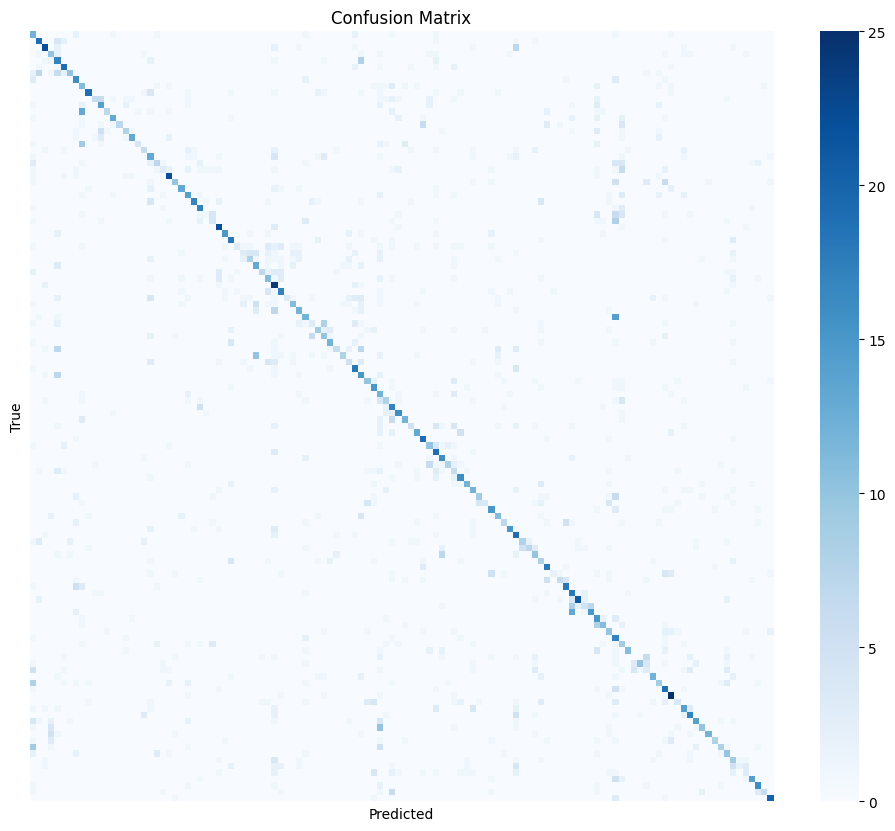

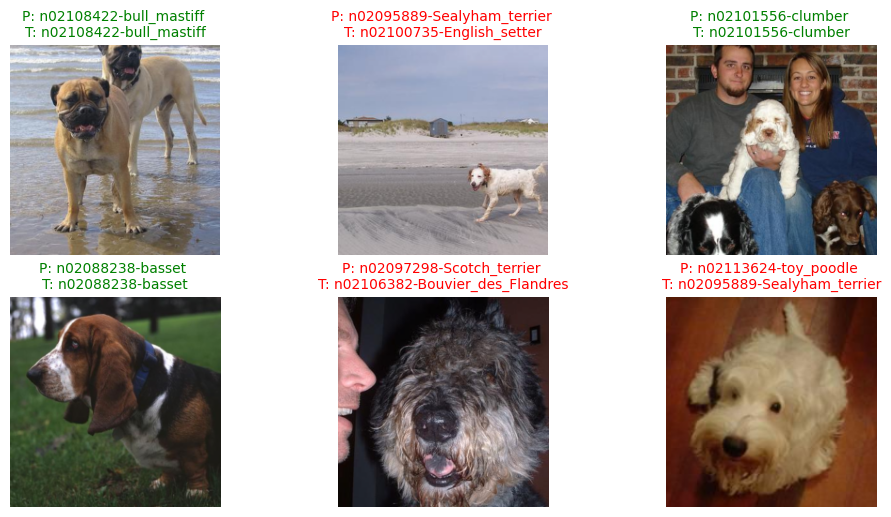

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Evaluate function
def evaluate_model(model, test_loader, device, class_names, model_path="best_model.pth", top_n=10, show_examples=True):
    # Best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Global accuracy
    acc = accuracy_score(all_labels, all_preds)
    display(Markdown(f"## ✅ Test Accuracy: {acc:.4f}"))

    # Classification report
    report_dict = classification_report(all_labels, all_preds, 
                                        target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()

    display(Markdown(f"### Top {top_n} Classes by Recall"))
    display(report_df.sort_values("recall", ascending=False)
            .head(top_n)[["precision","recall","f1-score","support"]])

    display(Markdown(f"### Top {top_n} Classes by Precision"))
    display(report_df.sort_values("precision", ascending=False)
            .head(top_n)[["precision","recall","f1-score","support"]])

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False, 
                fmt="d", annot=False, cbar=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Prediction examples
    if show_examples:
        show_predictions(model, test_loader.dataset, device, class_names, n=6)

evaluate_model(model, dataloaders["test"], device, class_names)

## 5. Cropping Images with Bounding Boxes  
### 5.1 Motivation
Up to this point, we have used the raw images from the dataset. However, the dataset also includes annotations that specify the exact coordinates of the dogs in each photo. Leveraging these bounding boxes allows us to focus the model's attention on the relevant regions, reduce background noise, and potentially improve classification performance.

---

### 5.2 Parsing Annotations

In [18]:
from xml.etree import ElementTree as ET
from PIL import Image
from tqdm import tqdm

# New section for cropping images with bounding boxes
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations", "Annotation")
OUTPUT_DIR = "dogs_cropped"

# Ensure all XML files have .xml extension
for root, dirs, files in os.walk(ANNOTATIONS_PATH):
    for f in files:
        old_path = os.path.join(root, f)
        if not f.lower().endswith(".xml"):
            os.rename(old_path, old_path + ".xml")

# Clean up any existing folders
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

classes = sorted(os.listdir(IMAGES_PATH))

# Image manipulation with annotations
for cls in tqdm(classes):
    cls_img_dir = os.path.join(IMAGES_PATH, cls)
    cls_ann_dir = os.path.join(ANNOTATIONS_PATH, cls)
    out_cls_dir = os.path.join(OUTPUT_DIR, cls)
    os.makedirs(out_cls_dir, exist_ok=True)

    for img_file in os.listdir(cls_img_dir):
        if not img_file.endswith(".jpg"):
            continue

        img_path = os.path.join(cls_img_dir, img_file)
        ann_file = img_file.replace(".jpg", ".xml")
        ann_path = os.path.join(cls_ann_dir, ann_file)

        if not os.path.exists(ann_path):
            display("Missing XML:", ann_path)
            continue

        # Parse XML
        tree = ET.parse(ann_path)
        root = tree.getroot()
        obj = root.find("object")
        if obj is None:
            continue

        bndbox = obj.find("bndbox")
        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        # Crop and save
        img = Image.open(img_path).convert("RGB")
        cropped_img = img.crop((xmin, ymin, xmax, ymax))
        cropped_img.save(os.path.join(out_cls_dir, img_file))

100%|██████████| 120/120 [00:39<00:00,  3.03it/s]


### 5.3 Train/Validation/Test Cropped Images

In [19]:
# Images path
CROPPED_PATH = "dogs_cropped_split"

# Clean up any existing folders
for folder in [CROPPED_PATH, "train", "test", "valid"]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Create output directories
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(CROPPED_PATH, split), exist_ok=True)

# Parameters
TEST_SIZE = 0.15
VALID_SIZE = 0.15

split_data(OUTPUT_DIR, CROPPED_PATH)

✅ Dataset split into train/valid/test in the folder: dogs_cropped_split

### 5.4 Cropped Images preprocessing

In [20]:
dataloaders_cropped, image_datasets_cropped = get_dataloaders(CROPPED_PATH)

✅ DataLoaders ready: with augmentation, normalization, and imbalance handling.

### 5.5 Training loop & Validation Cropped Images

In [22]:
cropped_trained_model, cropped_history = train_model(model.to(device), dataloaders_cropped, criterion, optimizer, num_epochs=EPOCHS, device=device, save_path="best_cropped_model.pth")

 Epoch 1/10  
--------------------

train Loss: 2.2645 Acc: 0.3928

valid Loss: 2.0785 Acc: 0.4350

 Epoch 2/10  
--------------------

train Loss: 2.0957 Acc: 0.4308

valid Loss: 1.8144 Acc: 0.4890

 Epoch 3/10  
--------------------

train Loss: 1.9866 Acc: 0.4501

valid Loss: 1.7586 Acc: 0.5113

 Epoch 4/10  
--------------------

train Loss: 1.9389 Acc: 0.4624

valid Loss: 1.7175 Acc: 0.5145

 Epoch 5/10  
--------------------

train Loss: 1.8944 Acc: 0.4760

valid Loss: 1.5787 Acc: 0.5423

 Epoch 6/10  
--------------------

train Loss: 1.8116 Acc: 0.4954

valid Loss: 1.5724 Acc: 0.5525

 Epoch 7/10  
--------------------

train Loss: 1.7518 Acc: 0.5114

valid Loss: 1.6543 Acc: 0.5356

 Epoch 8/10  
--------------------

train Loss: 1.6968 Acc: 0.5236

valid Loss: 1.5587 Acc: 0.5579

 Epoch 9/10  
--------------------

train Loss: 1.6693 Acc: 0.5357

valid Loss: 1.4626 Acc: 0.5761

 Epoch 10/10  
--------------------

train Loss: 1.5942 Acc: 0.5537

valid Loss: 1.5779 Acc: 0.5493


✅ Best Validation Accuracy: 0.5761

### 5.6 Final evaluation Cropped Test

## ✅ Test Accuracy: 0.5654

### Top 10 Classes by Recall

,precision,recall,f1-score,support
n02105641-Old_English_sheepdog,0.571429,0.923077,0.705882,26.0
n02092339-Weimaraner,0.379310,0.916667,0.536585,24.0
n02101556-clumber,0.552632,0.913043,0.688525,23.0
n02096585-Boston_bull,0.641026,0.892857,0.746269,28.0
n02105505-komondor,0.750000,0.875000,0.807692,24.0
n02100877-Irish_setter,0.583333,0.875000,0.700000,24.0
n02092002-Scottish_deerhound,0.600000,0.857143,0.705882,35.0
n02111889-Samoyed,0.595745,0.848485,0.700000,33.0
n02088632-bluetick,0.628571,0.846154,0.721311,26.0
n02104365-schipperke,0.666667,0.833333,0.740741,24.0


### Top 10 Classes by Precision

,precision,recall,f1-score,support
n02088466-bloodhound,1.000000,0.448276,0.619048,29.0
n02108915-French_bulldog,1.000000,0.500000,0.666667,24.0
n02112137-chow,0.961538,0.833333,0.892857,30.0
n02109525-Saint_Bernard,0.944444,0.653846,0.772727,26.0
n02112018-Pomeranian,0.923077,0.727273,0.813559,33.0
n02113023-Pembroke,0.916667,0.392857,0.550000,28.0
n02088094-Afghan_hound,0.896552,0.722222,0.800000,36.0
n02101006-Gordon_setter,0.882353,0.652174,0.750000,23.0
n02085782-Japanese_spaniel,0.882353,0.535714,0.666667,28.0
n02096177-cairn,0.857143,0.200000,0.324324,30.0


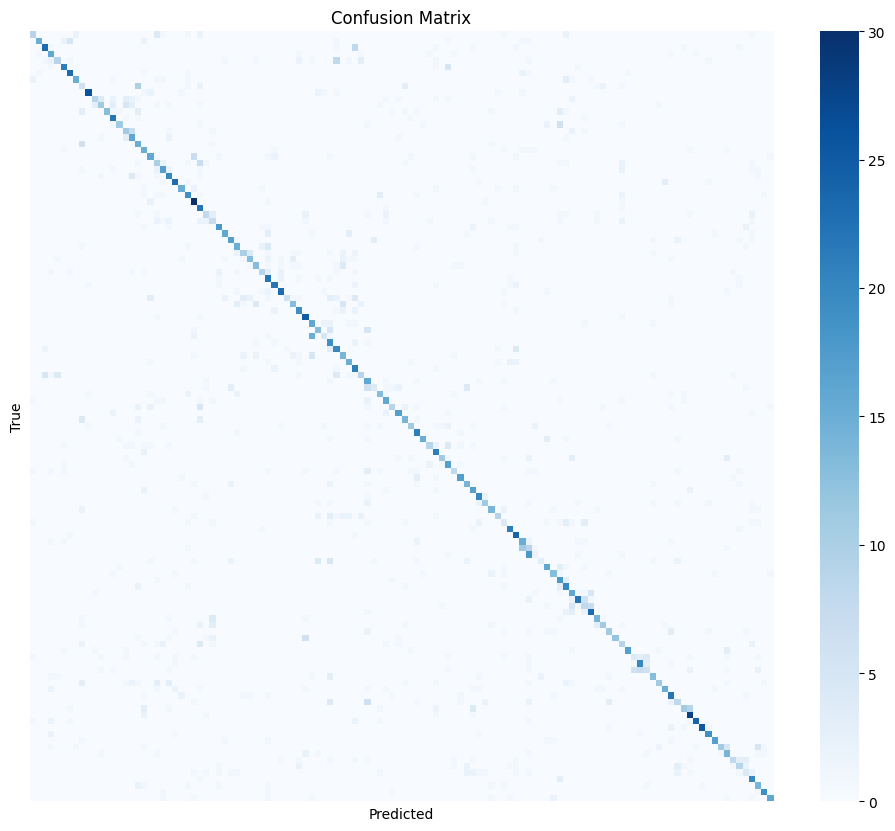

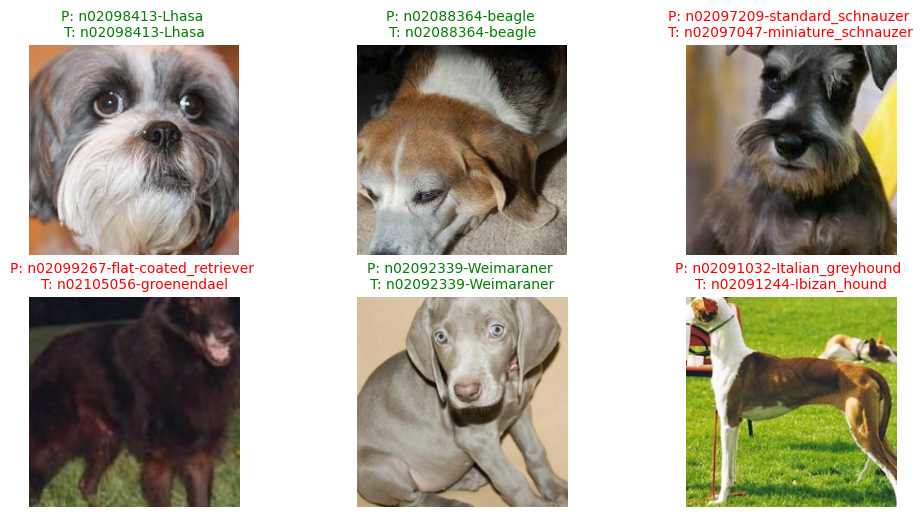

In [23]:
evaluate_model(cropped_trained_model, dataloaders_cropped["test"], device, class_names, model_path="best_cropped_model.pth")

## 6. Results and Discussion  

### 6.1 Raw vs Cropped Performance  

When evaluating the models trained on **Raw images** (no cropping) and **Cropped images** (centered on the dog), we observed a clear improvement:  

| Model   | Test Accuracy | Notable High-Recall Classes | Notable High-Precision Classes |
|---------|--------------|-----------------------------|--------------------------------|
| **Raw**     | 43.9%         | Bernese mountain dog (0.85) <br> Gordon setter (0.83) | Australian terrier (1.00, recall 0.07) <br> Golden retriever (1.00, recall 0.22) |
| **Cropped** | **56.5%**     | Old English sheepdog (0.92) <br> Weimaraner (0.92) <br> Clumber (0.91) | Bloodhound (1.00, recall 0.45) <br> Chow (0.96, recall 0.83) <br> Saint Bernard (0.94, recall 0.65) |

The **Cropped model outperforms the Raw model by more than 12 percentage points** in accuracy. This improvement confirms that focusing the network on the region of interest (the dog) reduces background noise and improves generalization.  

In the Raw setting, we found several classes with **perfect precision (1.0)** but **very low recall** (e.g., *cairn*, recall 0.10). This indicates that the model was extremely conservative: it predicted the class correctly when it did, but it missed most instances. In contrast, with Cropped images, the model not only kept precision high but also increased recall substantially, meaning it recognized more instances correctly without losing accuracy.  

---

### 6.2 Note on Top-10 Recall vs Top-10 Precision  

The top 10 classes by **recall** do not necessarily match the top 10 by **precision**.  

- **Recall** measures how many of the true instances of a class are correctly captured:  
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
$$  
A class can have high recall even if some predictions are incorrect (low precision).  

- **Precision** measures how accurate the predictions for a class are:  
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
$$  
A class can have high precision even if many true instances are missed (low recall).  

In short, a class may appear in the **Top-Recall list** because it is frequently detected, though not always accurately; while in the **Top-Precision list** it may appear because predictions are usually correct, but many true instances are missed. This distinction highlights the **complementary nature** of precision and recall when evaluating multi-class classifiers.  

---

### 6.3 Final Conclusion  

Overall, the results strongly support the use of **cropped images with bounding boxes** in fine-grained classification tasks such as dog breed recognition. While the Raw model demonstrated the ability to recognize certain breeds with very high precision, it struggled with recall due to background noise and non-discriminative features. By focusing the network on the dogs themselves, the Cropped model achieved **higher accuracy, stronger recall across multiple classes, and more balanced performance**, making it a more reliable solution for real-world deployment.  

---

## 7. Future Work

While the project demonstrates a solid pipeline for tackling the Stanford Dogs dataset —from raw images to cropped bounding boxes, modular training functions, and robust evaluation— there are several directions for improvement that could further enhance performance:

- **Transfer Learning with Deeper Architectures**  
  Exploring more powerful pre-trained models (e.g., ResNet-152, EfficientNet, or Vision Transformers) could provide a stronger feature extractor compared to ResNet-18.

- **Advanced Data Augmentation**  
  Techniques like Mixup, CutMix, or AutoAugment could increase data diversity and improve generalization.

- **Fine-tuning Hyperparameters**  
  Systematic hyperparameter tuning (e.g., using Optuna or Ray Tune) could optimize learning rate schedules, weight decay, and batch sizes for better convergence.

- **Class Imbalance Strategies**  
  Beyond weighted sampling, exploring focal loss or oversampling methods could improve performance on underrepresented breeds.

- **Cross-validation**  
  Applying k-fold cross-validation would give a more robust estimate of model performance across different dataset splits.

- **Ensembling**  
  Combining predictions from multiple models (e.g., raw images + cropped images) may reduce variance and improve accuracy.

- **Explainability and Interpretability**  
  Using Grad-CAM or similar techniques to visualize which parts of the image contribute most to the model’s decisions could add valuable insights.

This roadmap highlights how the current project can evolve into a more advanced and competitive solution, while still showcasing strong foundations in dataset handling, training optimization, and evaluation.

